In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import ast 


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_score,mean_squared_error
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

# Movie Recommendation Project

In this project we will try to predict which movie should be your next movie to watch, we will cover some interesting insights that we gained in the procees of creating this project.

### Project Outline

We seperated the project in to two main parts, Content based recommender and User based recommender in order to discuss and research two typical methods for building a recommender system.

**Content based filtering** the system will offer generalized recommendations to every user based on the specifics of each movie ( popularity, genres etc...). The basic idea behind this system is that the movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience.

We will try to answer and raise some interesting thoughts about:
- Genre popularity based on the year, can we tell by the yearly genre popularity if there was a major event that may have caused a specific genre to be more popular?
- What is the perfect runtime? is there such a thing?
- Is there a formula for a profitable and recommended movie?
- What is considered as a recommended movie?


**User Based /Collaborative Filtering** Later on, we will try to recommend a movie with adding demographic filtering based models. Giving a user a more specific recommendation on user with similar ratings to his. Also we will analyze the ratings dataset together with movies dataset.

In this part We managed to find interesting correlation between the users liked genres and other users.

## Table of Contents

- [Content-based Filtering](#Content-based-Filtering)
    - [Movie genres analysis](#Lets-look-at-at-the-movies's-genres)
    - [What is a recommended movie](#What-do-we-consider-a-recommended-movie?)
    - [Predicting if a movie will be recommended](#Lets-create-a-model-to-try-to-predict-if-a-movie-is-recommended)
    - [Content-based Filtering Summary](#Content-based-Filtering-Summary)
- [Collaborative Filtering](#Collaborative-Filtering)
    - [Understanding users liked genres](#Genre-Clustering-By-User-Ratings)
    - [Look at users ratings](#User-Based-Recommender)
    - [Choosing clusters number with elbow method](#Choosing-the-right-K-using-Elbow-Method)
    - [Recommending similar movies based on ratings](Compute-pairwise-correlation-of-ratings)
- [Movie Recommendation Conclusion](#Conclusion)


## Let's look at our data

In [2]:
# movies_raw_df = pd.read_csv('https://www.dropbox.com/s/mfe0v4ew5fmnyzb/movies.csv?dl=1')
# rating_raw_df = pd.read_csv('https://www.dropbox.com/s/tizyp5zreilielv/ratings.csv?dl=1')

movies_raw_df = pd.read_csv('movies.csv')
ratings_raw_df = pd.read_csv('ratings.csv')

#### MovieLens's Movies Dataset Features:

- adult - Is it an adult film
- budget - How much money was invested
- genres - Genres the movie classified to(JSON format)
- imdb_id - IMDb's ID
- overview - Description of the movie
- popularity - A numeric quantity specifying the movie popularity, the higher the better.
- production_companies - The production house of the movie.
- production_countries - The country in which it was produced.
- release_date - The date of the movie release
- revenue - How much revenue the movie generated worldwide
- runtime - How long is the movie in minutes
- tagline - Movie's tagline
- title - Title of the movie
- vote_average - average ratings the movie recieved.
- vote_count - the count of votes recieved.

#### Rating Dataset Features:

- userId - A unique value for each user
- movieId - A unique movie id in MovieLens
- rating - The user rating for that movie
- timestamp - The time the movie was rated

# Content-based Filtering

Content-based filtering methods are based on a description of the item (movie).
Content-based recommenders treat recommendation as a user-specific classification problem and learn a classifier for the user's likes and dislikes based on an item's features.

### Taking A Look At Our Movies Dataset

#### Cleaning MovieLens's Movies Dataset

REMOVED: 30 duplicates
REMOVED: 84 movies without release year
REMOVED: 40 movies without popularity
REMOVED: 437 movies that not released yet
Cleaning anomalies years, we are left with 1911 to 2017


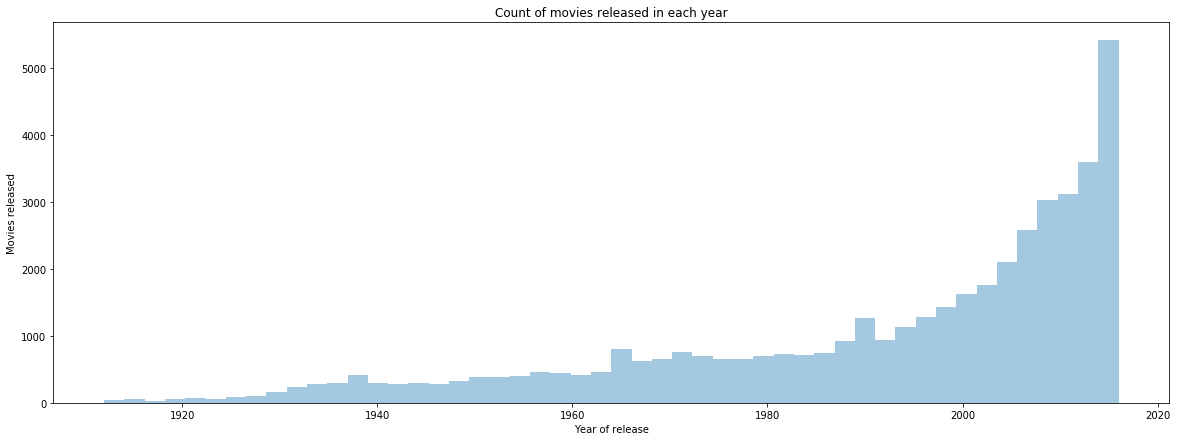

In [3]:
movies_df = movies_raw_df.copy()

# After inspections in df we found duplicated rows so we'll drop the to keep unique values
duplications = len(movies_df['id']) - len(movies_df.drop_duplicates(['id']))
print( 'REMOVED: {} duplicates'.format(duplications) )
movies_df.drop_duplicates(['id'],inplace=True)

# create a new column with the release year
movies_df['release_year'] = pd.to_datetime(movies_df['release_date'],errors='coerce').dt.year.fillna(0)
print( 'REMOVED: {} movies without release year'.format(len(movies_df[ movies_df['release_year'] == 0 ])) )
movies_df = movies_df[ movies_df['release_year'] != 0 ]

# clearing popularity column
movies_df['popularity'] = pd.to_numeric(movies_df['popularity'],errors='coerce')
print( 'REMOVED: {} movies without popularity'.format(len(movies_df[ movies_df['popularity'] == 0 ])) )
movies_df = movies_df[ movies_df['popularity'] != 0 ]

# Remove unreleased films
print( 'REMOVED: {} movies that not released yet'.format(len(movies_df[ movies_df['status'] != 'Released' ])) )
movies_df = movies_df[ movies_df['status'] == 'Released' ]

# finding the longest sequence of years with movie count higher then 10
def find_movies_range(df, threshold):
    # group by year
    groupby_year = df.groupby('release_year').size().reset_index(name='count').sort_values(['release_year'])
    # for each year, if it has sufficient number of movies
    groupby_year['count'] = groupby_year['count'].apply(lambda x: x < threshold)
    groupby_year.reset_index(inplace=True)
    # search for sequence of years with 10 >= movies
    groupby_year = groupby_year.groupby(groupby_year['count'].cumsum()).agg(
        {'release_year':['count', 'min', 'max']})
    groupby_year.columns = groupby_year.columns.droplevel()
    # get the longest year sequence in the dataset
    return groupby_year[groupby_year['count']==groupby_year['count'].max()]

years_range = find_movies_range( movies_df, 10 )

# clean movies out of limit
movies_df = movies_df[(movies_df['release_year'] > int(years_range['min'].values)) & (movies_df['release_year'] < int(years_range['max'].values))]

print('Cleaning anomalies years, we are left with {} to {}'.format(
    int(years_range['min'].values),int(years_range['max'].values))
)    


"""
Preparing our genres column for usage
Genres are stored as JSONs in our dataset, lets convert to it to hot-one format
"""
def genre_json_to_hotone( df ):
    genres_list = set()
    for index, row in df.iterrows():
        # extract genres
        movies_genres = ast.literal_eval(row['genres'])
        for genre in movies_genres:
            # if genre is not a column, generate the column and set all to 0
            if genre['name'] not in df:
                genres_list.add(genre['name'])
                df[ genre['name'] ] = 0
            df.at[index, genre['name']] = 1
    return genres_list

genres_list = genre_json_to_hotone( movies_df )

# removing unnecessary columns
movies_df.drop(['imdb_id','homepage','adult','belongs_to_collection','production_countries','overview','tagline',
                'video', 'genres','poster_path', 'spoken_languages','status'],inplace=True,axis=1)    

# Get a feeling of the movies and their release year
f, axes = plt.subplots(figsize=(20, 7))
sns.distplot(movies_df['release_year'], ax=axes, kde=False)
plt.xlabel('Year of release')
plt.ylabel('Movies released')
plt.title('Count of movies released in each year')
plt.show()

### Lets look at at the movies's genres

Popularity of movie genres can tell us a lot. in the following segment we will present how many movies in each genre were released each year.

Lets first look how many movies in each genre were released relative to all movies released in that year. 
As a movie can be considered in multiple genres, for our purposes if a movie has 3 genres, then all three are counted.

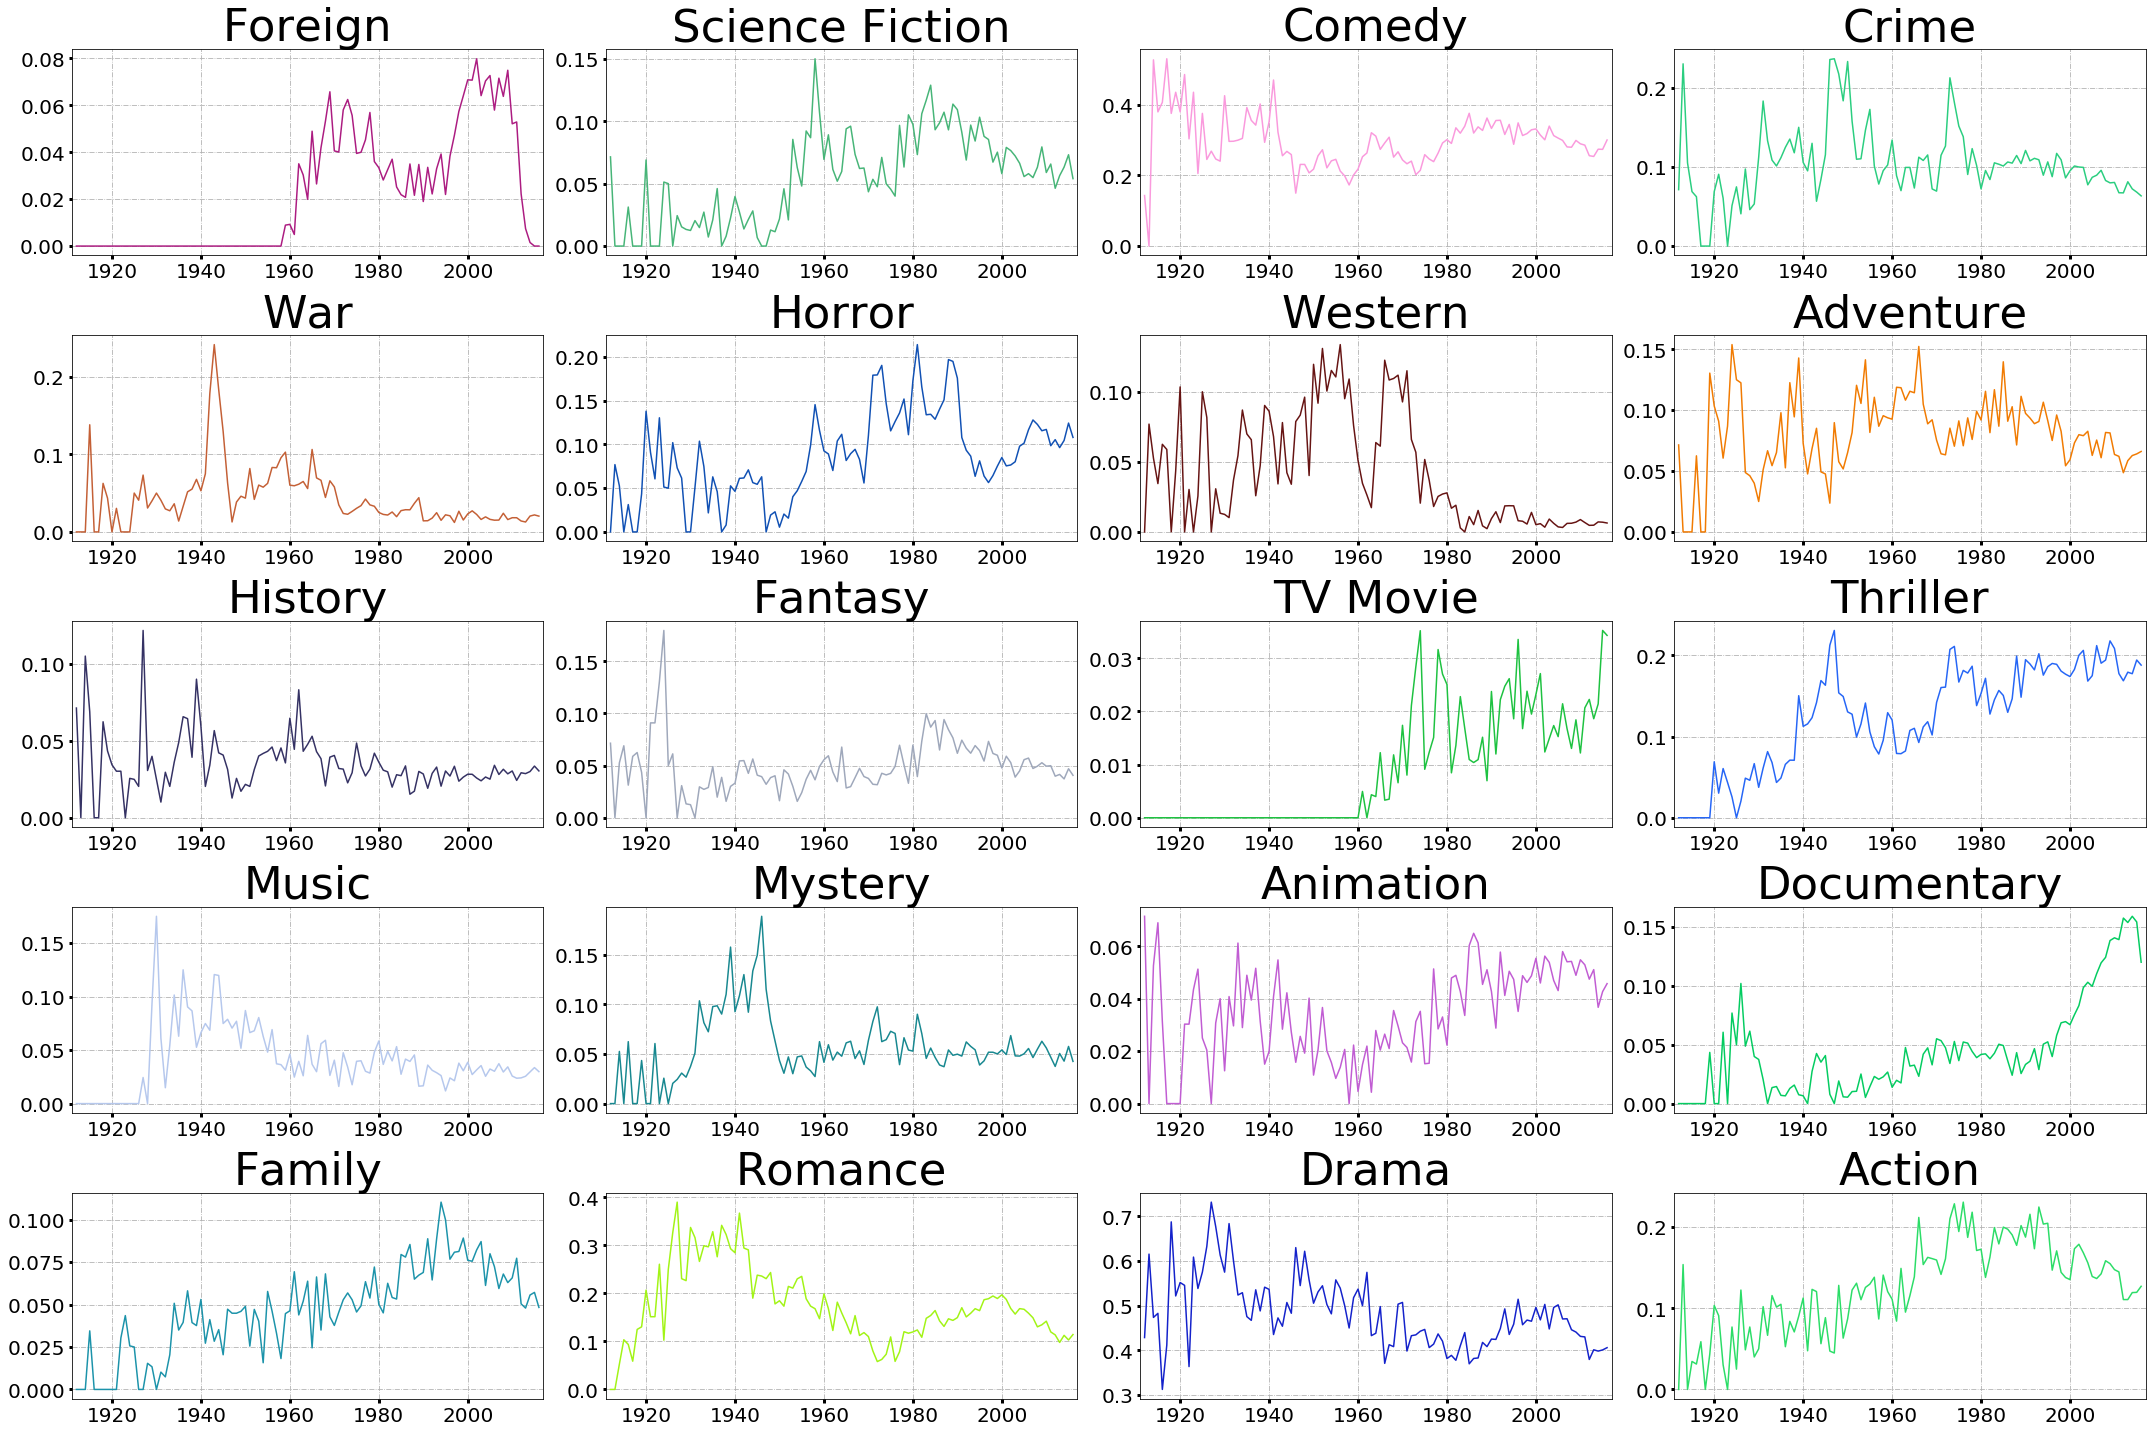

In [4]:
i = 1
fig, axes = plt.subplots(figsize=(30,20))

for genre in genres_list:
    ax = plt.subplot(5,4,i)
    
    d = movies_df[movies_df[genre] == 1].groupby(['release_year',genre]).size().to_frame('count').reset_index()
    d = d.set_index('release_year').drop(genre,axis=1)['count'] / movies_df.groupby('release_year').size()
    d.fillna(0,inplace=True)
    
    sns.lineplot(data=d,color=np.random.rand(3,))
    
    ax.grid(True, linestyle='-.')
    ax.tick_params(labelsize=20, width=3)
    plt.ylabel('')
    plt.xlabel('')
    # plt.ylim(bottom=0,top=1)
    plt.xlim(left=years_range['min'].values,right=years_range['max'].values)
    plt.title(genre, {'size' : '45'})
    i+=1
    
plt.tight_layout()
plt.show()

Combining the count of movies released in each year with the following plot, which is showing the median popularity of each 
movie genre in each year we can notice for some interesting insights #todo WTF??? Ron this is an old sentence?

#### Some of the insights we can come across while understanding the plots:

- Steady disappearance of Westerns.
- Burst of Musicals onto the scene in the mid-1920s, then declining since the 1970s.
- Link between Film-Noir and WW2? #todo where is Film-noir
- Dwindling popularity of Romance and Action in recent years.
- Increasing popularity of documentaries since the mid 90s.
- Slow increase in popularity of Horror and Thrillers since the 1950s.
- Increase of TV movies as TVs were introduced in the 1940s

This will allow us to tell, in a given year and a genre the propability it will be popular

### What do we consider a recommended movie?

We will consider a movie recommended if he have a weighted rate above average. this movie will have a higher probability of being liked by the average audience.

#### Normalizing our ratings

[based on IMDb's formula](https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV#)

> How do you calculate the rank of movies and TV shows on the Top Rated Movies and Top Rated TV Show lists?
The following formula is used to calculate the Top Rated 250 titles. This formula provides a true 'Bayesian estimate', which takes into account the number of votes each title has received, minimum votes required to be on the list, and the mean vote for all titles:

`weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C`

Where:
- R = average for the movie (mean) = (rating)
- v = number of votes for the movie = (votes)
- m = minimum votes required to be listed in the Top Rated list
- C = the mean vote across the whole report

Notice that the Top Rated Movies Chart only includes theatrical features: shorts, TV movies, miniseries and documentaries are not included in the Top Rated Movies Chart. The Top Rated TV Shows Chart includes TV Series, but not TV episodes or Movies.

In [5]:
def calculate_weighted_rate(row):
    m = movies_df['vote_count'].quantile(0.9)
    c = movies_df['vote_average'].mean()
    v = row['vote_count']
    r = row['vote_average']
    res = (v / (v+m)) * r + (m / (v+m)) * c
    return res

movies_df['weighted_rate'] = movies_df.apply(calculate_weighted_rate,axis=1)

movies_df[['original_title','vote_average','weighted_rate']].head()

,original_title,vote_average,weighted_rate
0,Toy Story,7.7,7.639919
1,Jumanji,6.9,6.820204
2,Grumpier Old Men,6.5,5.946166
3,Waiting to Exhale,6.1,5.712889
4,Father of the Bride Part II,5.7,5.666944


In [6]:
# the recommended film column based on mean
wr_mean = movies_df['weighted_rate'].mean()

# drop the columns that weight rate is based on them
movies_df['recommended'] = movies_df.apply(lambda x: 'True' if x['weighted_rate']>=wr_mean else 'False' ,axis=1)
movies_df.head()

,budget,id,original_language,original_title,popularity,production_companies,release_date,revenue,runtime,title,...,Science Fiction,Mystery,War,Foreign,Music,Documentary,Western,TV Movie,weighted_rate,recommended
0,30000000,862,en,Toy Story,21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]",30/10/1995,373554033,81.0,Toy Story,...,0,0,0,0,0,0,0,0,7.639919,True
1,65000000,8844,en,Jumanji,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",15/12/1995,262797249,104.0,Jumanji,...,0,0,0,0,0,0,0,0,6.820204,True
2,0,15602,en,Grumpier Old Men,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",22/12/1995,0,101.0,Grumpier Old Men,...,0,0,0,0,0,0,0,0,5.946166,True
3,16000000,31357,en,Waiting to Exhale,3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,22/12/1995,81452156,127.0,Waiting to Exhale,...,0,0,0,0,0,0,0,0,5.712889,False
4,0,11862,en,Father of the Bride Part II,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...",10/02/1995,76578911,106.0,Father of the Bride Part II,...,0,0,0,0,0,0,0,0,5.666944,False


### Lets create a model to try to predict if a movie is recommended

The model will try to predict if a movie will have an above avarage rate just by the runtime, popularity and the movie's genres.

#### Lets train our model

At first the recommendation prediciton will be based on the runtime, popularity and genres columns.

We will use 3 different models, and we will choose the best one.

In [7]:
movies_data_df = movies_df.drop(columns=['id','original_title', 'title','release_date','revenue','budget',
                                         'weighted_rate','vote_average', 'vote_count'])

def combine_features(row):
    feature = row['original_language'] 
    for company in ast.literal_eval(row['production_companies']):
        try:
            feature += " " + company['name']
        except:
            pass
    return feature

movies_data_df["combined_features"] = movies_df.apply(combine_features,axis=1)
movies_data_df["combined_features"].fillna('',inplace=True)
movies_data_df['runtime'].fillna(0,inplace=True)
movies_data_df.drop(columns=['production_companies', 'original_language','combined_features'],inplace=True)
movies_data_df.head()

,popularity,runtime,release_year,Animation,Comedy,Family,Adventure,Fantasy,Romance,Drama,...,History,Science Fiction,Mystery,War,Foreign,Music,Documentary,Western,TV Movie,recommended
0,21.946943,81.0,1995.0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
1,17.015539,104.0,1995.0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,True
2,11.712900,101.0,1995.0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,True
3,3.859495,127.0,1995.0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,False
4,8.387519,106.0,1995.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False


In [8]:
Xs = movies_data_df.drop('recommended',axis=1)
y = movies_data_df['recommended']
X_train,X_test,y_train,y_test = train_test_split(Xs,y,test_size=0.20,random_state=0)
X_train.shape,X_test.shape


ML_models = {}
model_index = ['LR','RF','NN']
model_sklearn = [LogisticRegression(solver='liblinear',random_state=0),
                 RandomForestClassifier(n_estimators=100,random_state=0),
                 MLPClassifier([100]*5,early_stopping=True,learning_rate='adaptive',random_state=0)]

model_summary = []

for name,model in zip(model_index,model_sklearn):
    ML_models[name] = model.fit(X_train,y_train)
    preds = model.predict(X_test)
    model_summary.append([name,f1_score(y_test,preds,average='weighted'),accuracy_score(y_test,preds),
                          roc_auc_score(y_test,model.predict_proba(X_test)[:,1]),])\
    
print(ML_models)

model_summary = pd.DataFrame(model_summary,columns=['Name','F1_score','Accuracy','AUC_ROC'])
model_summary = model_summary.reset_index()
display(model_summary)

{'LR': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), 'RF': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False), 'NN': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, ea

,index,Name,F1_score,Accuracy,AUC_ROC
0,0,LR,0.814021,0.827337,0.864917
1,1,RF,0.842552,0.846458,0.895548
2,2,NN,0.817574,0.829713,0.883772


### Content-based Filtering Summary

We tested 3 different algorithms and found out that the most accurate one to predict a 'recommended movie' is RandomForestClassifier algorithm by looking at the 3 measures it is significantly the best performer.

Lets explain the AUC - ROC Curve measure. as it is an essntial measure to understand how our classifier is preforming on classifing our movies as "Recommended" or Not.
##### What is AUC - ROC Curve?

>AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. By analogy, Higher the AUC, better the model is at distinguishing between patients with disease and no disease.
The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis.

From the AUC - ROC Curve we can understand that our RF Classifier Can differentiate between the recommened and not recommended movies in the optimal way.


#### Finding the optimal paramaters for the most profitable and recommended movie

In the following example, we will find out the optimal specifics a movie needs to have in order to be profitable 
(in terms of revenue / budget ) and to be considered recommended, which is what all movie makers seek . We will look at the top 1000 recommended and most profitable movies.

Using [median of medians](https://en.wikipedia.org/wiki/Median_of_medians)(The median of medians is a simple approximate selection algorithm) to find the optimal runtime and counting how many movies released in each genre we will produce the optimal formula for a movie.

Optimal runtime is between 96 to 125 minutes

The top profitble genres are:
Drama, Comedy, Action, Romance, Horror

Popularity of those films is between 7 to 14
While the popularity median of all movies is 1.14, with max value being 547.49 and the standard deviation is 5.33

Genres median popularity scatter over the years:


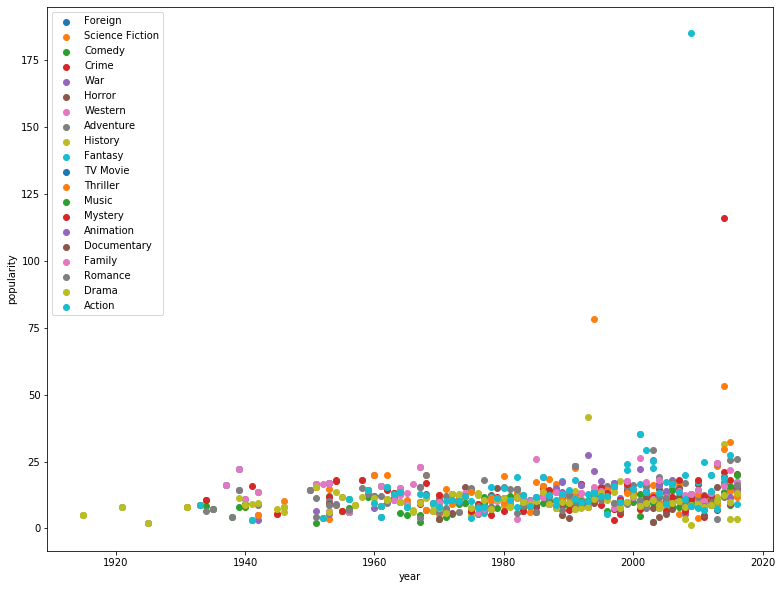

In [9]:
movies_earn_df = movies_df[ \
    ( movies_df['revenue'] > 10**3) & (movies_df['budget'] > 10**3) & (movies_df['recommended'] == 'True') \
    ].copy()

movies_earn_df['r/b'] = movies_earn_df.apply(lambda x: (x['revenue'] / x['budget']),axis=1)
movies_earn_df.sort_values(by=['r/b'],ascending=False,inplace=True)
movies_earn_df.reset_index(inplace=True)
movies_earn_df = movies_earn_df.head(1000)

runtime_opt_range = {
    'min': int(movies_earn_df[ movies_earn_df['runtime'].median() > movies_earn_df['runtime'] ]['runtime'].median()),
    'max': int(movies_earn_df[ movies_earn_df['runtime'].median() < movies_earn_df['runtime'] ]['runtime'].median())
}

print('Optimal runtime is between {} to {} minutes'.format(runtime_opt_range['min'], runtime_opt_range['max']))

genres_count = pd.DataFrame(columns=genres_list,
                            index=np.arange(years_range['min'].values,years_range['max'].values))
genres_popularity_sum = pd.DataFrame(columns=genres_list,
                                    index=np.arange(years_range['min'].values,years_range['max'].values))

fig = plt.figure(figsize=[13,10])
axes = fig.add_subplot()

for genre in genres_list:
    # find size of movies in a genre per year
    genres_count[genre] = movies_earn_df[movies_earn_df[genre] == 1].groupby('release_year').size()    
    # caculate median popularity for each genre and year
    genre_pop = movies_earn_df[movies_earn_df[genre] == 1].groupby('release_year') \
        ['popularity'].median()
    axes.scatter(x=genre_pop.index, y=genre_pop.values, label=genre,)

axes.set_xlabel('year')
axes.set_ylabel('popularity')
genres_count.fillna(0,inplace=True)
genres_popularity_sum.fillna(0,inplace=True)

print('\nThe top profitble genres are:')
print(*genres_count.max().sort_values(ascending=False).head().index, sep = ", ")

popularity_range = {
    'min': int(movies_earn_df[ movies_earn_df['popularity'].median() > movies_earn_df['popularity'] ]['popularity'].median()),
    'max': int(movies_earn_df[ movies_earn_df['popularity'].median() < movies_earn_df['popularity'] ]['popularity'].median())
}

print('\nPopularity of those films is between {} to {}'.format(popularity_range['min'], popularity_range['max']))
print('While the popularity median of all movies is {:.2f}, with max value being {:.2f} and the standard deviation is {:.2f}'.format(movies_df['popularity'].median(),movies_df['popularity'].max(),movies_df['popularity'].std()) )

print('\nGenres median popularity scatter over the years:')
plt.legend();
plt.show()

We can notice that except for the years 2009 for Fantasy (right after Avatar movie was released) and 2014 for Mystery (Right after the Purge movies started being released) which are anamolies because of their budget and revenue(Avatar broke the recored for the most profitable movie. The first Purge movie budget was 3 million dollars) most of the profitable and recommended movies have a pretty consistant popularity.

We can't control how popular a movie will be, this is up to the audience to decide, but we can see that they are not exteremly more popular than not recommended movies.  #todo break text to more lines, its to much ine one sentence

---

# Collaborative Filtering

Collaborative filtering is a way recommendation systems filter information by using the preferences of other people.
It uses the assumption that if person A has similar preferences to person B on items they have both reviewed,
then person A is likely to have a similar preference to person B on an item only person B has reviewed.

## Genre Clustering By User Ratings

**Our key goal here will be to understand the users favorite genres or their watching habits based on their ratings, then to  recommend this user some movies based these preferences.**

First we will be creating a DataFrame with each user's avarage rating for each genre. Ratings are between 1 to 5, movies that are not rated we will set the rating to zero.

In [10]:
generes_df = movies_raw_df.loc[:, ('genres', 'title', 'id')]
generes_df.drop_duplicates(['id'], inplace=True)
generes_df.dropna()

# Preparing our genres column for usage
genres_list = genre_json_to_hotone( generes_df )

generes_df.drop(columns=['genres'], inplace=True)
generes_df.set_index('id', inplace=True)

In [11]:
genre_ratings = pd.DataFrame()

for genre in genres_list:
    genre_movies = generes_df[generes_df[genre] == 1]
    avg_genre_votes_per_user = ratings_raw_df[ratings_raw_df['movieId'].isin(genre_movies.index)] \
        .loc[:, ['userId', 'rating']] \
        .groupby(['userId'])['rating'].mean()
    genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
genre_ratings.columns = genres_list

# fill 0 if user didn't rate the genre
genre_ratings.fillna(0,inplace=True)

#### Getting a feeling of our data

Now when the data is clean and set for use, as we can see we have 265k users with ratings on 20 genres, we can choose the right clustering methodology.

In [12]:
print(genre_ratings.head(3))

print('\nData size: {}'.format(genre_ratings.shape))

   Foreign  Science Fiction  Comedy     Crime  War  Horror  Western  \
1      3.5              0.0    4.25  4.500000  0.0     0.0      0.0   
2      0.0              4.0    2.80  3.000000  3.0     4.0      0.0   
3      0.0              3.0    3.20  2.666667  0.0     0.0      0.0   

   Adventure  History  Fantasy  TV Movie  Thriller  Music  Mystery  Animation  \
1        0.0      0.0     0.00       0.0       0.0    0.0      1.0        0.0   
2        3.5      3.5     3.25       0.0       4.0    1.0      3.5        0.0   
3        0.0      0.0     3.00       0.0       2.5    0.0      3.0        0.0   

   Documentary  Family   Romance  Drama  Action  
1          5.0     0.0  3.333333  4.125    3.50  
2          0.0     1.5  4.000000  3.000    3.75  
3          0.0     0.0  3.333333  3.400    3.00  

Data size: (265848, 20)


### Getting a feeling of working with K-Means and our dataset

Our methodology choice of clustering is the K-Means algorithm, it works by grouping N observations in K(Arbitary number chosen by the user) clusters, where each observation belongs to the cluster with the nearest mean. First lets take a look at the pros and cons of this algorithm.

**Pros(took 3 major pros of the algorithm):**
1. Simple: It is easy to implement k-means and identify unknown groups of data from complex data sets. The results are presented in an easy and simple manner.
2. Suitable in a large dataset: K-means is suitable for a large number of datasets and it’s computed much faster than the smaller dataset. It can also produce higher clusters.
3. Time complexity: K-means segmentation is linear in the number of data objects thus increasing execution time. It doesn’t take more time in classifying similar characteristics in data like hierarchical algorithms.
4. Spherical clusters: This mode of clustering works great when dealing with spherical clusters. It operates with an assumption of joint distributions of features since each cluster is spherical. All the clusters features or characters have equal variance and each is independent of each other.

**cons**
1. NoNo-optimal set of clusters: K-means doesn’t allow development of an optimal set of clusters and for effective results, you should decide on the clusters before.
2. Lacks consistency: K-means clustering gives varying results on different runs of an algorithm. A random choice of cluster patterns yields different clustering results resulting in inconsistency.
3. Sensitivity to scale: Changing or rescaling the dataset either through normalization or standardization will completely change the final results.

#### We will start with observing a subset of the Data Set.
Lets look at a subsample of the users who rated Comedy and Horror and search for a correlation between the ratings.
We deliberately chose genres with different aspects so we may find interesting hidden patterns within the users habits.


### #1 Choose The K numbers of clusters
To determine the right K number of clusters we can use 3 methodolgies:
    1. Business decision - To correspond to business values that are needed to group a certain amounts of clusters.
    2. Elbow Method - The elbow method is the preferred method for data science to deteremine the right k clusters needed to be in the Data Set. It works by plotting the ascending values of K versus the average silhouette score for each clusters
    predictions of the data.
    3. Field knowledge - Based on past experience with the Data we may choose the k by it.
    

##### Choosing the right K using Elbow Method
>Silhouette refers to a method of interpretation and validation of consistency within clusters of data. The technique provides a succinct graphical representation of how well each object has been classified.

>The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

The goal of elbow method is to find the k that for each cluster will not significantly raise the Avg. Silhouette score. 

To achieve this we will plot the wanted K's from 2 to 30( for more than 30 cluster will be hard to visualize) so we want to catch the correct k in this range.

After Looking at the plot below, we can see that the best choices of the K values are: 6,9, 24, 27. Increasing the number of clusters beyond that range result in worst clusters according to the Silhouette Score.
We will chose the K = 6 as it is the one that yields the best score and will be easiest to visualize. #todo and to explain we are looking for the elbows in the graph and do a big check on full data

running on k: 2
running on k: 3
running on k: 4
running on k: 5
running on k: 6
running on k: 7
running on k: 8
running on k: 9
running on k: 10
running on k: 11
running on k: 12
running on k: 13
running on k: 14
running on k: 15
running on k: 16
running on k: 17
running on k: 18
running on k: 19
running on k: 20
running on k: 21
running on k: 22
running on k: 23
running on k: 24
running on k: 25
running on k: 26
running on k: 27
running on k: 28
running on k: 29


Text(0, 0.5, 'Avg. Silhouette Score')

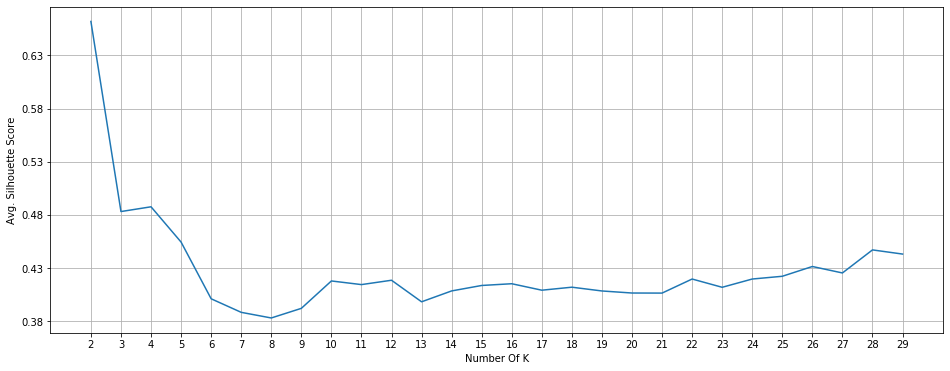

In [13]:
# Lets get only the Pepole who rated movies that related to comedy and adventure genres
comedy_horror_df = genre_ratings[['Comedy','Horror']]
comedy_horror_df = comedy_horror_df[(comedy_horror_df['Comedy']>=1) | (comedy_horror_df['Horror']>=1)]

X = comedy_horror_df.sample(int(len(comedy_horror_df)*0.05))

# Choose the range of k values to test.
possible_k_values = range(2, 30)

def clustering_errors(k, data):
    print('running on k: {}'.format(k))
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 1.0)

ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')

yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)

ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')
ax.set_xlabel("Number Of K")
ax.set_ylabel("Avg. Silhouette Score")

### #2 Cluster the Data and Plot it using scatter plot

Now after we know the correct K that is needed for our K-Means model, we can take the two genres and first, train and predict the model on them. Then we will plot the clusters using scatter plot so we could gain some insights from it.

As in Pros #4 (Spherical clusters) K-Means is an algorithm built for Gaussian data.  When we apply it to a dataset like movie genre preference, we are likely to encounter normally distributed data, for which the algorithm is appropriate.  To show how we will use K-Means on the dataset, we first implement it on a subset of the data.  The subset is not necessarily Gaussian, and so the algorithm will be less successful.  Later, we will use it on the full data then we could see how its advantages coming to our favor.

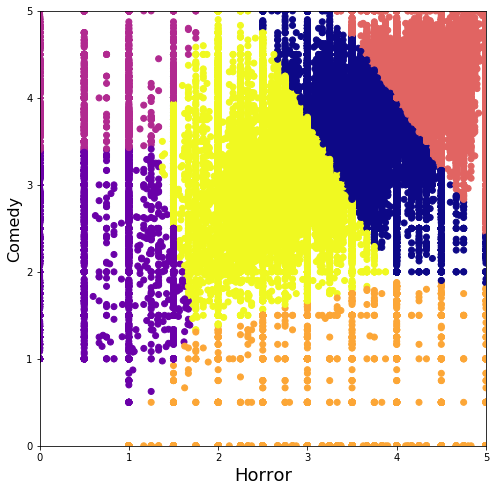

In [14]:
comedy_horror_df = genre_ratings[['Comedy','Horror']]
comedy_horror_df = comedy_horror_df.loc[(comedy_horror_df['Comedy']>=1) | (comedy_horror_df['Horror']>=1)]

number_clusters = 6

X_comedy_horror = comedy_horror_df.values

# Lets create an object of KMeans and cluster comedy and Horror genres 
kmeans_model = KMeans(n_clusters=number_clusters)
predictions = kmeans_model.fit_predict(X_comedy_horror)

# Defining the cluster
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

plt.xlim(0, 5)
plt.ylim(0, 5)
ax.set_ylabel('Comedy',fontsize=16)
ax.set_xlabel('Horror',fontsize=18)
clustered = pd.concat([comedy_horror_df.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
plt.scatter(comedy_horror_df['Horror'],comedy_horror_df['Comedy'],c=predictions, cmap='plasma')


**We can see that model divides the users to groups by its avg watching rate of each of the genres , for example people who rates Horror and Comedy high will be grouped together.**


### All Genres Clustering

Now we will evaluate our full dataset.

Based on three methodolgies to choose the right K as noted above, We chose an arbitrary k number (k=20) based on Business decision as we have 20 genres in our data. 
Next, we train and predict our K-Means Model on our data and analyse those clusters. After that, we will plot each cluster as a heatmap  to spot certain trends and commonalities in each cluster it might help us to figure how the model is clustering the users by their watching habits.



In [15]:
# lets try to take 80% of the data and get some interesting insights
subsample_amount = int(genre_ratings.shape[0]*0.8)
subsample_rated_df = genre_ratings[:subsample_amount]

# 20 clusters are detrmined and reorder the df
model = KMeans(n_clusters=20,random_state=1)
predictions = model.fit_predict(subsample_rated_df)
clustered = pd.concat([subsample_rated_df.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
clustered.rename(columns={"index": "User"},inplace=True)
clustered.set_index("User",inplace=True)
# clustered.drop(columns=['num_of_ratings'],inplace=True)

#### Lets look at our clusters, and identify some interests and insights

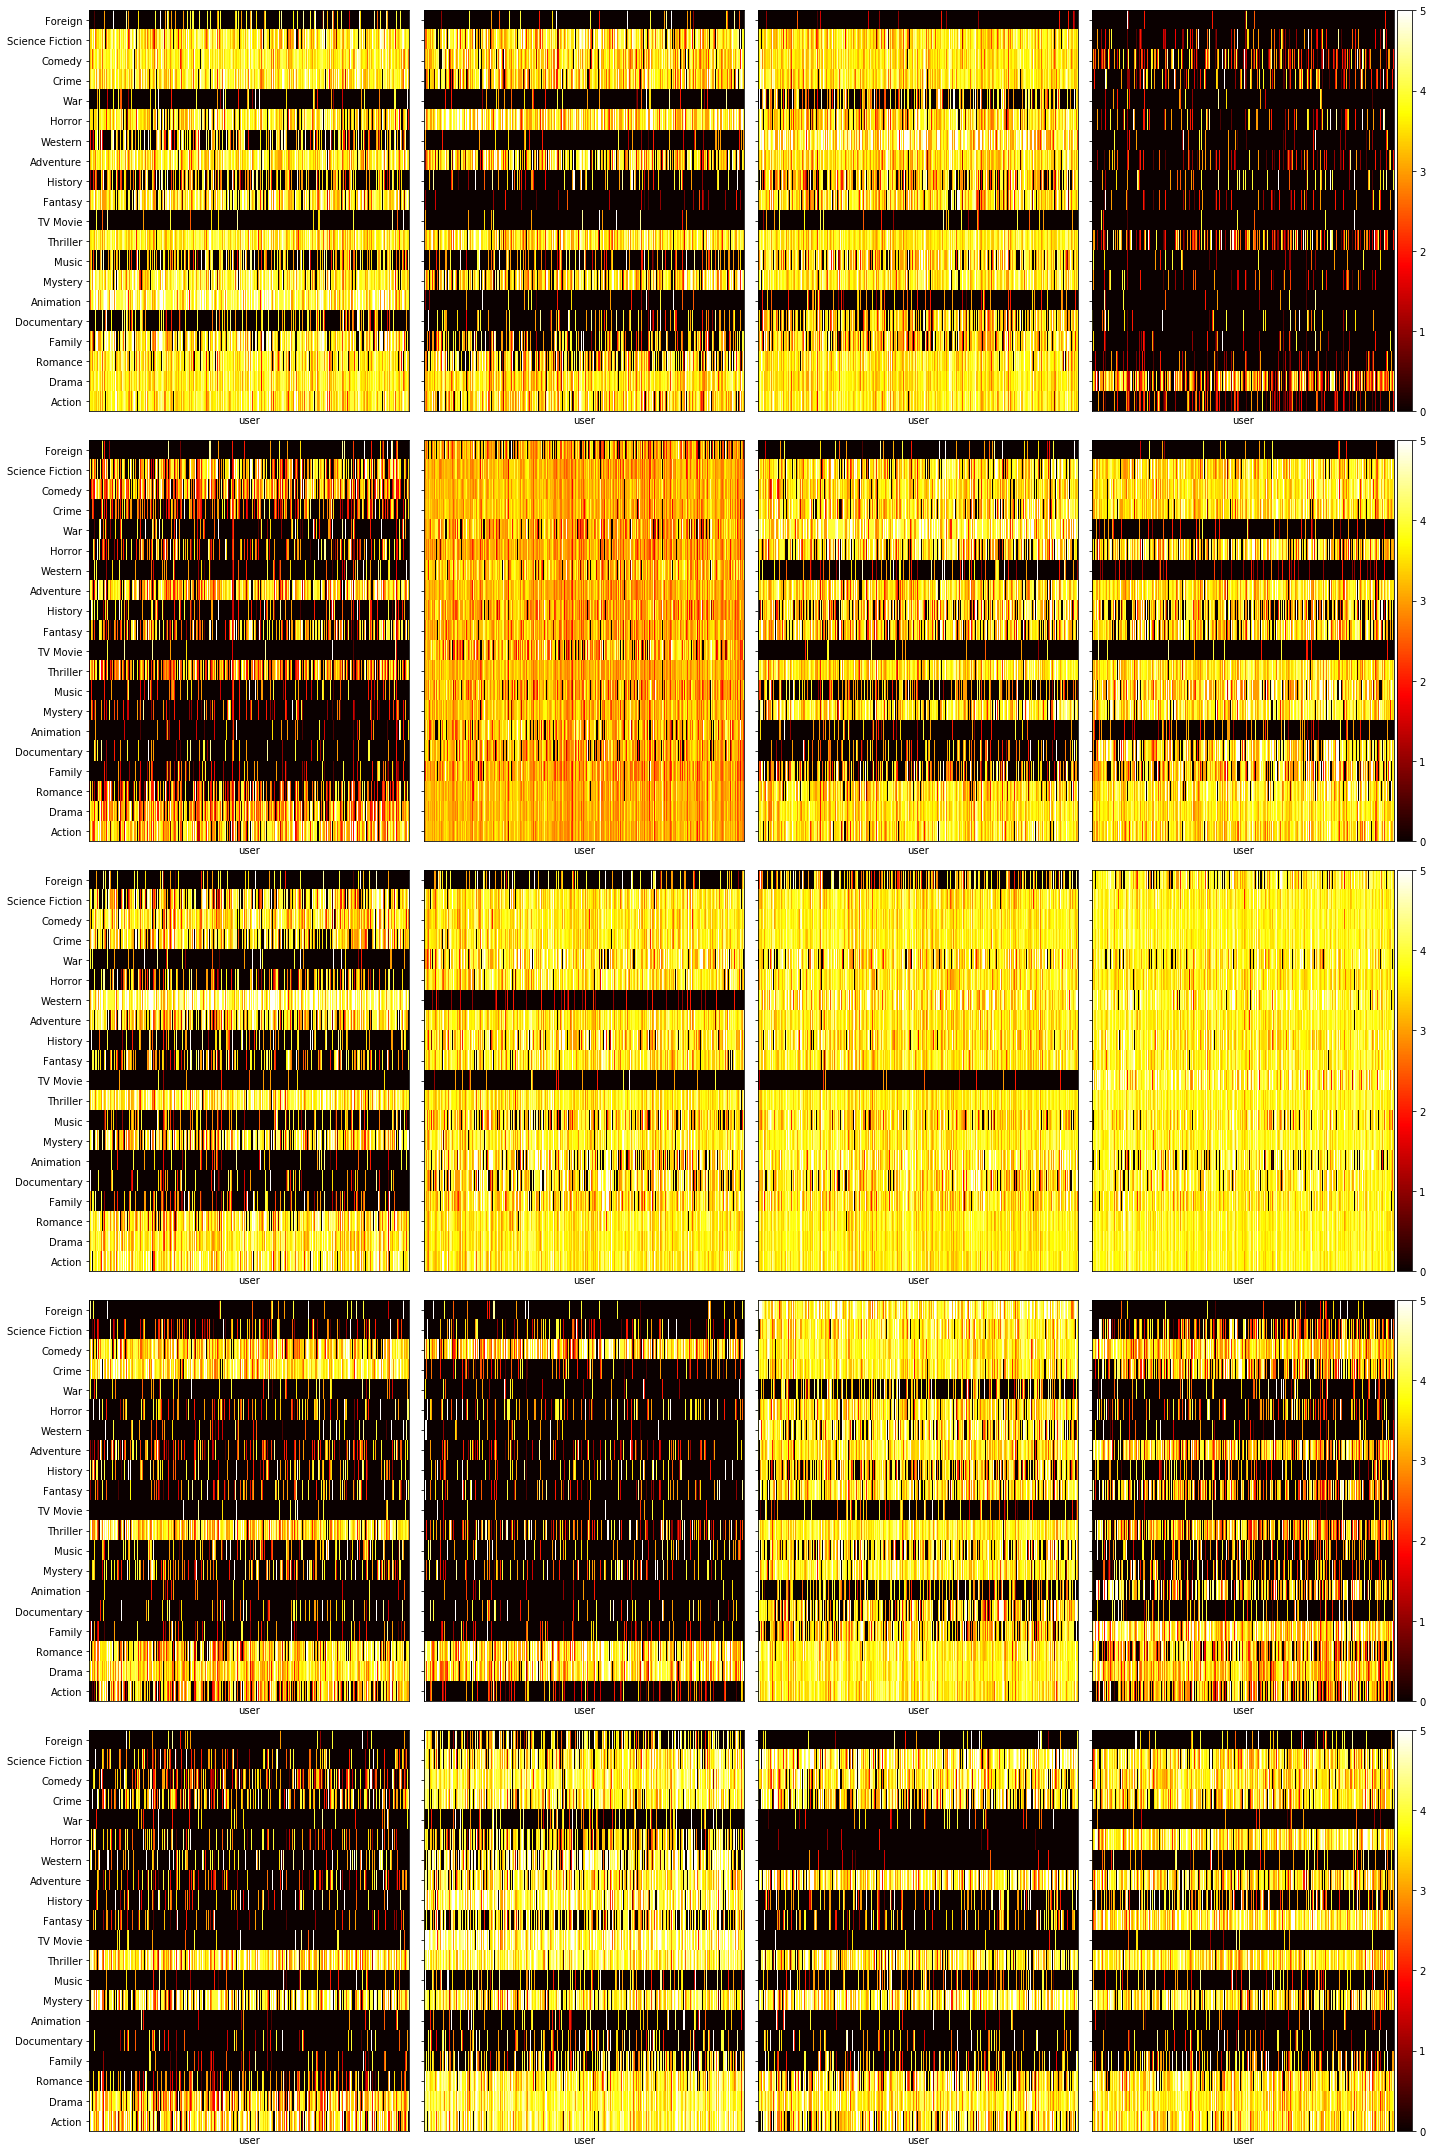

In [16]:
fig, axes = plt.subplots(figsize=(20,30))

for i in range(1,21):
    ax = plt.subplot(5,4,i)
    data = clustered[clustered['group']==(i-1)].copy().drop(columns=['group'])
    heatmap = ax.imshow(data.transpose(), vmin=0, vmax=5, aspect='auto', cmap='hot')

    ax.set_xticks([])
    ax.set_yticks(np.arange(data.shape[1]))

    ax.set_yticklabels([])
    plt.setp(ax.get_xticklabels(), rotation=90)
    
    ax.set_xlabel("user")
    if( i%4==1 ):
        ax.set_yticklabels(data.columns, minor=False)
        
    if( i%4==0 ):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        # Color bar
        cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
        cbar.ax.set_xticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','no rating'])

plt.tight_layout()
plt.show()

###### We can notice specific insights in these heatmaps:

* Some clusters are more sparse, the others maybe really dense. It's  shows us that the model tends to cluster users that have simillar watching habits.  
* Some users tend to watch specific genres only, they dont watch any other genres.
* Vertical lines with constant color correspond to users with low variety in their ratings, they tend to like or dislike most of the movies.
* The more vertical lines of the same color in the cluster, the more similar the ratings will be in that cluster.


Our method of recommendation will be:
- Spot the top 5 highest genres ratings in each cluster and consider them to define this cluster,
- Given a user, associate them with a cluster.
- After predicting a user's cluster, we will recommend those high values genres of the cluster they are associated to.


To summarize this we'll see now the correlation of the cluster genres avg. ratings to the users. 

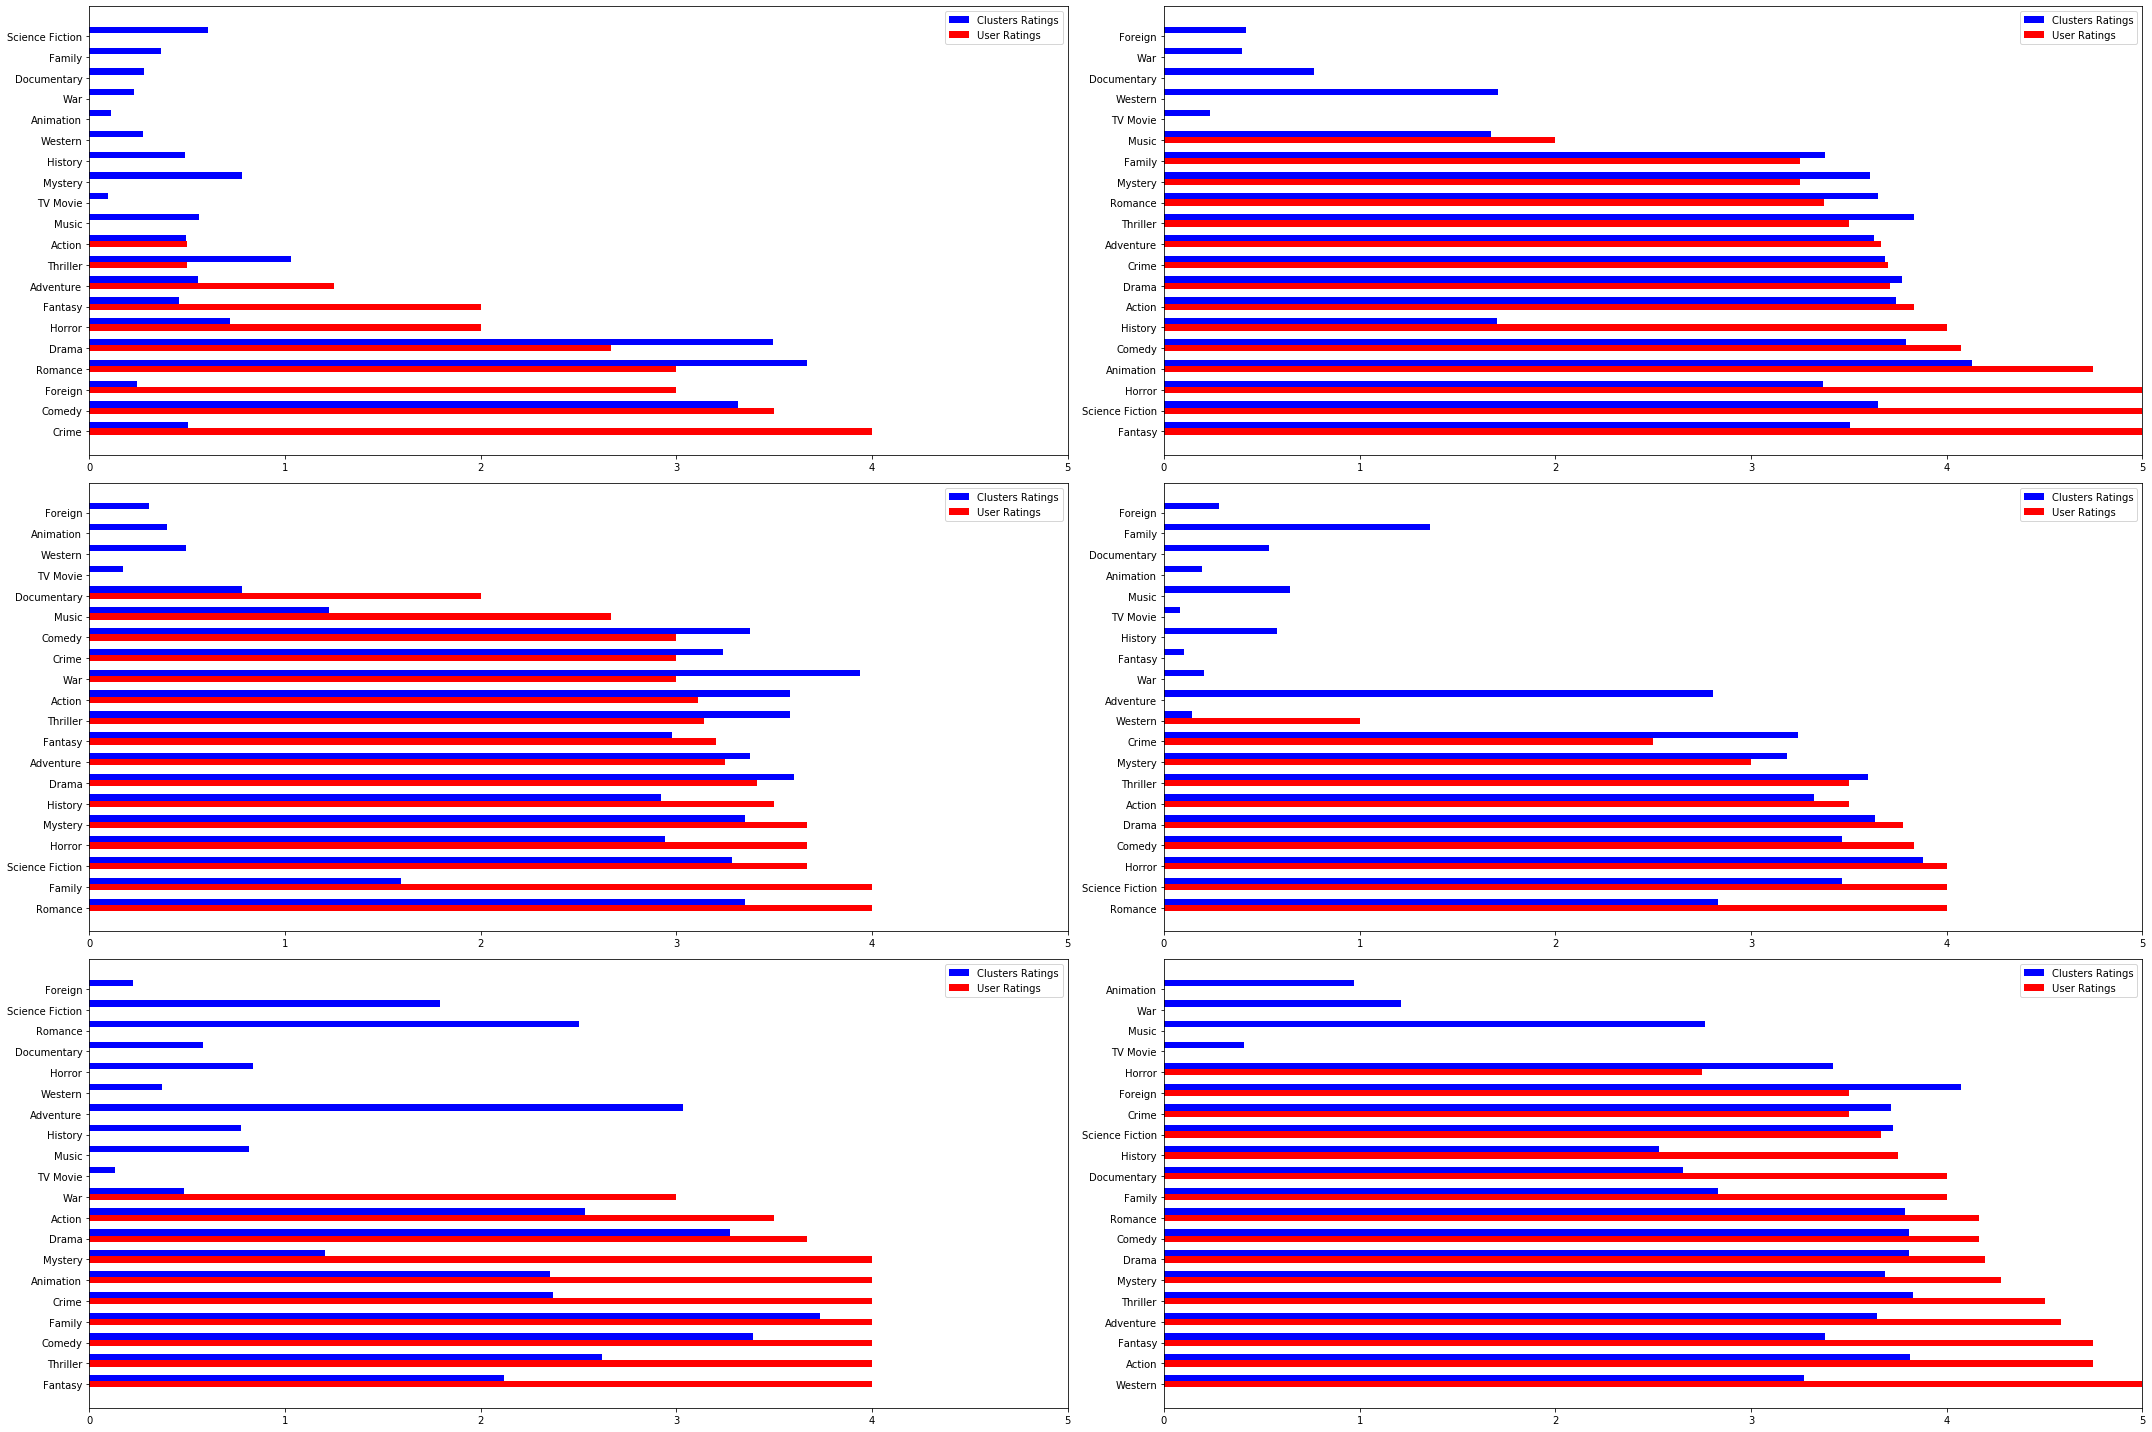

In [17]:
# lets get a user out of the  "test" users so we could predict its cluster and analyze its watching habits.
full_genres_df = genre_ratings.reset_index()
full_genres_df.rename(columns={"index": "user"},inplace=True)

sampled_rated_df = subsample_rated_df.reset_index()
sampled_rated_df.rename(columns={"index": "user"},inplace=True)

sampled_rated_list = list(sampled_rated_df['user'])
test_df = full_genres_df[~(full_genres_df['user'].isin(sampled_rated_list))][:6] #Taking some users
test_df = test_df.set_index('user')

# predict its cluster and analyse this clusters genres ratings
test_predictions = model.predict(test_df)

fig, axes =  plt.subplots(figsize=(30,20))

for i in range(6):
    ax = plt.subplot(3,2,i+1)
    users_ratings = test_df.iloc[i].sort_values(ascending=False)
    users_ratings = pd.DataFrame({'genres':users_ratings.index,'user_ratings':users_ratings.values}) 
    cluster_related_user = clustered[clustered['group']==test_predictions[i]].drop(columns=['group'],axis=1)
    cluster_related_user = cluster_related_user.mean()
    cluster_related_user = pd.DataFrame({'genres':cluster_related_user.index,'clusters_ratings':cluster_related_user.values}) 
    merged = users_ratings.merge(cluster_related_user,on='genres')
    merged.set_index('genres',inplace=True)
    
    # merged.plot.barh(rot=0,xlim=(0,5))
    x = np.arange(len(merged.index))
    
    ax.barh(x+0.3 ,merged['clusters_ratings'], height=0.3, color='b', align='center',label = 'Clusters Ratings')
    ax.barh(x ,merged['user_ratings'], height=0.3, color='r', align='center',label = 'User Ratings')
    
    ax.set_yticks(x)
    ax.set_yticklabels(merged.index)
    ax.set_xlim(0,5)
    ax.legend()
    
plt.tight_layout()
plt.show()    


------

## User Based Recommender

This time instead of recommending movies based on the genres the user rated, we will recommend movies by other users rating similar movies.

As we have a big dataset of user ratings, we can achieve this recommendation model easily by finding the correlation between the users rating.

Lets prepare our data first.

In [18]:
userIds = np.random.randint(int(ratings_raw_df['userId'].min()),int(ratings_raw_df['userId'].max()),1000)

ratings_df = pd.DataFrame(ratings_raw_df.columns)
ratings_df = ratings_raw_df[ratings_raw_df['userId'].isin(userIds)].copy()

# convert rating timestamp to date
ratings_df['date'] = ratings_df.apply(lambda x: str(datetime.fromtimestamp(x['timestamp']).strftime('%Y-%m-%d')),axis=1)
#extract release year
ratings_df['vote_year'] = pd.to_datetime(ratings_df['date']).dt.year

In the original dataset each user rating was a row. After merging the user ratings with the movies dataset(in order to get the movie title), we will pivot the DF, that way we will have in each row a user with his ratings of each movie.

#### Get a feeling of the ratings data set

Lets check out the movies rating years and checking the ratings means distributions. # todo what is this row means?
#todo add y label to plot

movies rating years distributions


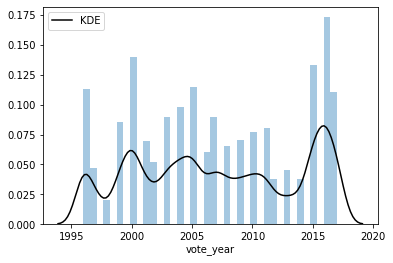

count of ratings


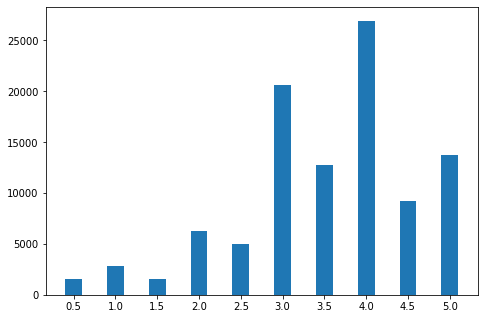

In [19]:
print('movies rating years distributions')
sns.distplot(ratings_df['vote_year'],
                  kde_kws={"color": "k","label": "KDE"})
plt.show()

print('count of ratings')

ratings_count = ratings_df.groupby(by=['rating']).size()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xticks(ratings_count.index, minor=False)
ax.bar(ratings_count.index,ratings_count.values,width=0.2)
plt.show()

We can see that most of the votes are higher than 3, with the most popular vote 4.

### Compute pairwise correlation of ratings

We will find the correlation between the ratings with Pearson correlation coefficient.
#todo add about pearson correlation

In [20]:
ratings_movies_df = pd.merge(movies_df,ratings_df,
                             how="left", left_on='id', right_on='movieId') \
                            .loc[:, ('movieId','title','userId','rating')]

# remove movies with less then 10 ratings
user_ratings_df = ratings_movies_df.pivot_table(index=['userId'],columns=['title'],values='rating')
user_ratings_df = user_ratings_df.dropna(thresh=5, axis=1).fillna(0,axis=1)

print(user_ratings_df.shape)

(976, 1340)


In [21]:
corr_matrix = user_ratings_df.corr(method='pearson')
corr_matrix.head(10)

title,!Women Art Revolution,10 Items or Less,10 Things I Hate About You,2 Days in Paris,"20,000 Leagues Under the Sea",2001: A Space Odyssey,2010,24 Hour Party People,25th Hour,28 Days Later,...,Young Adam,Young Black Stallion,Young Frankenstein,Young and Innocent,Zatoichi,Zatôichi's Pilgrimage,Zodiac,eXistenZ,xXx,À nos amours
title,,,,,,,,,,,,,,,,,,,,,
!Women Art Revolution,1.000000,-0.007357,0.324290,0.031132,0.093975,0.071429,-0.004685,-0.004767,0.137740,0.099217,...,-0.011761,-0.003973,-0.010879,0.131793,0.017925,0.039493,-0.006672,-0.005182,0.112012,-0.006297
10 Items or Less,-0.007357,1.000000,0.152885,0.379013,0.269723,0.057424,0.158342,-0.007928,0.034703,0.081112,...,0.072054,-0.006607,0.035352,0.180181,0.128987,0.289377,0.306865,0.521390,0.077650,0.235276
10 Things I Hate About You,0.324290,0.152885,1.000000,0.085940,0.186208,0.014293,-0.004918,-0.005004,0.309253,0.169922,...,0.083327,0.225591,0.079385,0.126021,0.167343,0.103316,-0.007004,-0.005439,0.247055,0.223010
2 Days in Paris,0.031132,0.379013,0.085940,1.000000,0.247372,0.075192,0.185841,0.234214,0.194726,0.168226,...,0.085384,0.019346,0.149508,0.131085,0.105329,0.374213,0.393469,0.529135,0.087472,0.110223
"20,000 Leagues Under the Sea",0.093975,0.269723,0.186208,0.247372,1.000000,0.160827,0.132784,0.015173,0.292668,0.215775,...,0.199927,0.057073,0.098689,0.173004,0.184052,0.128070,0.204545,0.312045,0.071129,0.078512
2001: A Space Odyssey,0.071429,0.057424,0.014293,0.075192,0.160827,1.000000,0.007908,0.014973,0.148585,0.054803,...,0.300128,-0.009662,0.046065,0.042676,0.176015,0.114987,0.168528,0.150288,0.037003,0.016958
2010,-0.004685,0.158342,-0.004918,0.185841,0.132784,0.007908,1.000000,-0.005049,0.031498,0.019666,...,-0.012457,-0.004208,0.038164,0.022377,-0.014927,-0.005368,-0.007067,0.235163,0.044184,-0.006669
24 Hour Party People,-0.004767,-0.007928,-0.005004,0.234214,0.015173,0.014973,-0.005049,1.000000,-0.009643,0.075489,...,0.160607,-0.004281,-0.011723,0.034414,0.057522,-0.005461,0.137791,-0.005584,0.076296,0.126893
25th Hour,0.137740,0.034703,0.309253,0.194726,0.292668,0.148585,0.031498,-0.009643,1.000000,0.179997,...,0.042669,0.113567,0.191686,0.134960,0.079939,0.144870,0.159496,0.196018,0.101914,0.067016


Now that we have the correlation between movies based on the users rating, we will try to recommend a movie.

Each user rating will be normalized by subtracting 2.5 from the user's rating, that way if the rating is low it will be a negative number and will not be recommended. Then we will sort by the result of the multiplication to present the highest results.

#### Now lets check what we get

Lets take Ron for example, he likes action movies especially Batman, but doesn't like old fashion action

In [22]:
def get_similar(movie_name,rating):
    similar_ratings = corr_matrix[movie_name]*(rating-2.5)
    similar_ratings = similar_ratings.sort_values(ascending=False)
    return similar_ratings

rons_movies = [
    ("Rocky",2),
    ("Die Hard",3),
    ("28 Days Later", 2),
    ("Batman Begins",5),
    ("Mission: Impossible",4)]

similar_movies = pd.DataFrame()
for movie,rating in rons_movies:
    similar_movies = similar_movies.append(get_similar(movie,rating),ignore_index = True)

similar_movies.head(10)

,!Women Art Revolution,10 Items or Less,10 Things I Hate About You,2 Days in Paris,"20,000 Leagues Under the Sea",2001: A Space Odyssey,2010,24 Hour Party People,25th Hour,28 Days Later,...,Young Adam,Young Black Stallion,Young Frankenstein,Young and Innocent,Zatoichi,Zatôichi's Pilgrimage,Zodiac,eXistenZ,xXx,À nos amours
0,0.002338,-0.119904,0.002454,-0.050247,-0.013338,-0.072974,0.002476,0.002519,-0.031051,-0.058701,...,-0.024894,0.002100,-0.072186,-0.061057,-0.044445,-0.079747,-0.057208,-0.064506,-0.060939,-0.102449
1,0.008954,0.159469,0.085218,0.140701,0.070956,0.034926,0.062921,0.083512,0.043562,0.052710,...,0.026878,0.041782,0.017637,0.094837,0.089175,0.059348,0.060038,0.116447,0.063083,0.159534
2,-0.049609,-0.040556,-0.084961,-0.084113,-0.107887,-0.027402,-0.009833,-0.037745,-0.089998,-0.500000,...,-0.037980,-0.024591,-0.102330,-0.064421,-0.027542,-0.052634,-0.050647,-0.055509,-0.095691,-0.068759
3,-0.030830,0.340232,-0.032362,0.214901,0.396884,0.387866,-0.032655,0.162963,0.102232,-0.002345,...,0.442769,-0.027688,0.006974,0.158657,0.323163,0.141626,0.439838,0.366019,-0.015293,0.162200
4,0.041287,0.486612,0.305325,0.595449,0.320893,0.193926,0.197549,0.123907,0.261522,0.135974,...,0.070496,0.027569,0.104395,0.232570,0.322518,0.402277,0.476159,0.641290,0.161851,0.244497


In [23]:
similar_movies.sum().sort_values(ascending=False).head(20)

Batman Begins              2.494575
Mission: Impossible        1.526463
Rumble Fish                1.229137
Notting Hill               1.110440
Murder, My Sweet           1.074257
Lili Marleen               1.073046
The Soft Skin              1.071396
Only the Lonely            1.052543
Galaxy Quest               1.030776
Die Hard                   1.024665
Catwoman                   1.023141
Paradise Found             1.021547
Alien                      1.016359
eXistenZ                   1.003740
The Godfather: Part III    0.991252
Eyes Wide Shut             0.981269
Touch of Evil              0.972208
Hulk                       0.968029
The Breakfast Club         0.949135
Los Olvidados              0.938592
dtype: float64

----

# Conclusion

We discussed here two typical methods for building a recommender system. we started with a Content-based Filtering approach, in that part, we cleaned our data set(for example ranges of years without enough data). First, we analyzed the data, saw how popular a genre is based on the number of movies released for that genre. We saw some interesting insights for example how world events may cause a rise in specific genre popularity. Later on, we build a model to predict if a movie is recommended to users based on his metadata and with that model we saw what makes a recommended movie profitable.

Our next method that we researched was the Collaborative Filtering approach. First, we checked the difference between users who like horror movies and users who like comedy, we used the elbow-method to find the number of clusters to classify our data and with that, we managed to find some surprising results. Later on, we classified all our user ratings for all the genres and tried to find some more broad clusters using heatmaps. We finished this method with a simple recommendation algorithm to find similar movies to the ones the user liked.

We saw that each method has its limitation and biases, we came to the conclusion that in order to have a better recommendation system we will need to utilze both Collaborative Filtering and Content-Based filtering. This requires fine-tuning the balance between the approaches.

Our results might have some inaccuracies, but we feel that the overall goal of our project was reached. we managed to get insightful data that can help us to refine the recommendation model further.  